# Project Title: Classifying News Articles
## Project Overview:
- Build a model that classifies news headlines into categories like Sports, Politics, Business, etc.

## Scope:

Build a multi-class text classification model to assign one of 5–7 possible categories to each news headline.
Compare classic ML methods (e.g., Logistic Regression) with a simple deep learning model (e.g., LSTM or GRU).
Evaluate models using accuracy, precision, and confusion matrix.

### Data Set -  News Category Dataset (from data.world)

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tuhin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# ----------------------
# 2. Load Dataset
# ----------------------
# dataset: HuffPost news category dataset (from data.world / Kaggle)
df = pd.read_json(r"C:\Users\Tuhin\OneDrive\Desktop\Classifying News Articles\News_Category_Dataset_v3.json", lines=True)
# Focus only on headline + categor
df = df[['headline', 'category']]

df.head()

,headline,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS


In [3]:
# ----------------------
# 3. Filter Categories (5–7 classes)
# ----------------------
# Map original categories into broader ones
mapping = {
    'POLITICS': 'politics',
    'WORLD NEWS': 'politics',
    'BUSINESS': 'business',
    'TECH': 'tech',
    'SCIENCE': 'tech',
    'SPORTS': 'sports',
    'ENTERTAINMENT': 'entertainment',
    'STYLE & BEAUTY': 'lifestyle',
    'TRAVEL': 'lifestyle',
    'PARENTS': 'lifestyle',
    'WELLNESS': 'lifestyle'
}

df['category_mapped'] = df['category'].map(mapping)
df = df.dropna(subset=['category_mapped'])

# Keep only selected categories
df = df[df['category_mapped'].isin(['politics','business','tech','sports','entertainment','lifestyle'])]

print("Dataset shape:", df.shape)
print(df['category_mapped'].value_counts())

Dataset shape: (113256, 3)
category_mapped
lifestyle        41614
politics         38901
entertainment    17362
business          5992
sports            5077
tech              4310
Name: count, dtype: int64


In [4]:
# ----------------------
# 4. Preprocessing Function
# ----------------------
def preprocess_text(text):
    """Lowercase, remove punctuation, stopwords"""
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [w for w in text.split() if w not in STOPWORDS]
    return " ".join(tokens)

df['clean_text'] = df['headline'].apply(preprocess_text)

In [5]:
# ----------------------
# 5. Label Encoding
# ----------------------
le = LabelEncoder()
df['label'] = le.fit_transform(df['category_mapped'])

In [6]:
# ----------------------
# 6. Train-Test Split
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], 
    test_size=0.2, stratify=df['label'], random_state=42
)

In [7]:
# ================================================================
# Baseline Model: TF-IDF + Logistic Regression
# ================================================================
print("\n=== Baseline: TF-IDF + Logistic Regression ===")

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_lr, target_names=le.classes_))


=== Baseline: TF-IDF + Logistic Regression ===
               precision    recall  f1-score   support

     business       0.70      0.41      0.52      1198
entertainment       0.81      0.75      0.78      3473
    lifestyle       0.80      0.91      0.85      8323
     politics       0.86      0.90      0.88      7781
       sports       0.84      0.60      0.70      1015
         tech       0.77      0.42      0.54       862

     accuracy                           0.82     22652
    macro avg       0.80      0.66      0.71     22652
 weighted avg       0.82      0.82      0.81     22652



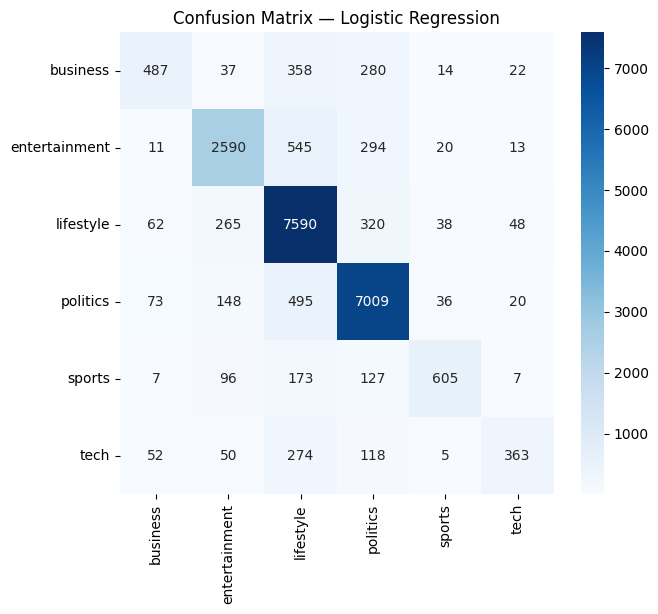

In [8]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(7,6))
sns.heatmap(cm_lr, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

In [9]:
# ================================================================
# Deep Learning Model: LSTM + GloVe Embeddings
# ================================================================
print("\n=== Deep Learning: LSTM + GloVe Embeddings ===")

# Tokenization
MAX_NB_WORDS = 20000
MAX_SEQ_LEN = 30
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LEN)



=== Deep Learning: LSTM + GloVe Embeddings ===


In [10]:
# Load GloVe embeddings (glove.6B.100d.txt required)
embeddings_index = {}
with open(r"C:\Users\Tuhin\OneDrive\Desktop\Classifying News Articles\glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

word_index = tokenizer.word_index
num_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
# Build LSTM model
lstm_model = Sequential([
    Embedding(num_words, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), 
              input_length=MAX_SEQ_LEN, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(len(le.classes_), activation="softmax")
])

lstm_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer="adam", metrics=["accuracy"])

history = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=128,
    verbose=1
)

Epoch 1/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 67s 93ms/step - accuracy: 0.6813 - loss: 0.9461 - val_accuracy: 0.8062 - val_loss: 0.5695
Epoch 2/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 45s 79ms/step - accuracy: 0.7902 - loss: 0.6400 - val_accuracy: 0.8203 - val_loss: 0.5310
Epoch 3/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - accuracy: 0.8050 - loss: 0.5884 - val_accuracy: 0.8279 - val_loss: 0.5044
Epoch 4/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8195 - loss: 0.5528 - val_accuracy: 0.8339 - val_loss: 0.4870
Epoch 5/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.8275 - loss: 0.5312 - val_accuracy: 0.8379 - val_loss: 0.4776


In [12]:
# Evaluation
y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad), axis=1)
print(classification_report(y_test, y_pred_lstm, target_names=le.classes_))

708/708 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
               precision    recall  f1-score   support

     business       0.68      0.44      0.54      1198
entertainment       0.83      0.75      0.79      3473
    lifestyle       0.84      0.90      0.87      8323
     politics       0.86      0.91      0.88      7781
       sports       0.83      0.72      0.77      1015
         tech       0.65      0.59      0.62       862

     accuracy                           0.84     22652
    macro avg       0.78      0.72      0.75     22652
 weighted avg       0.83      0.84      0.83     22652



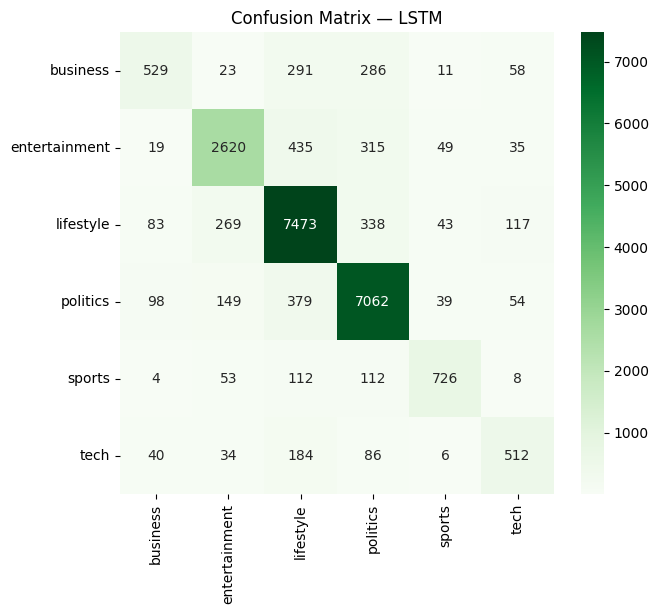

In [13]:
# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(7,6))
sns.heatmap(cm_lstm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.title("Confusion Matrix — LSTM")
plt.show()

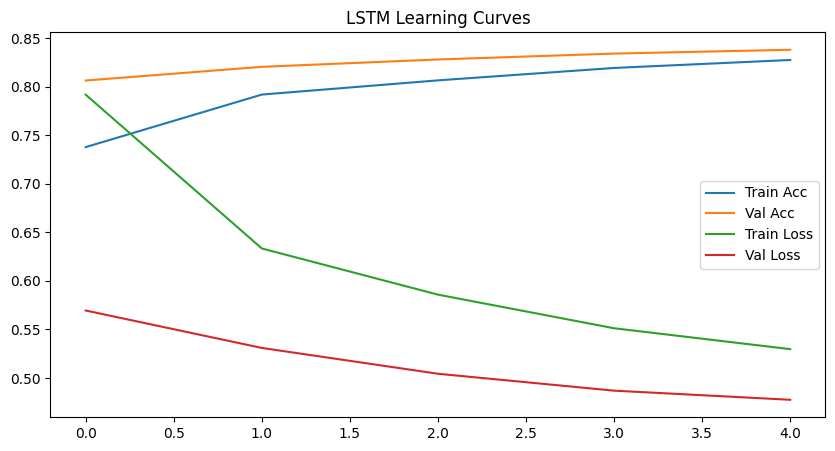

In [14]:
# Learning Curves
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("LSTM Learning Curves")
plt.show()

In [15]:
# ================================================================
#  Results Comparison
# ================================================================
results = pd.DataFrame([
    {"Model": "Logistic Regression", 
     "Accuracy": accuracy_score(y_test, y_pred_lr),
     "Precision": precision_score(y_test, y_pred_lr, average="macro"),
     "Recall": recall_score(y_test, y_pred_lr, average="macro"),
     "F1": f1_score(y_test, y_pred_lr, average="macro")},
    
    {"Model": "LSTM + GloVe", 
     "Accuracy": accuracy_score(y_test, y_pred_lstm),
     "Precision": precision_score(y_test, y_pred_lstm, average="macro"),
     "Recall": recall_score(y_test, y_pred_lstm, average="macro"),
     "F1": f1_score(y_test, y_pred_lstm, average="macro")}
])

print("\n=== Model Comparison ===")
print(results)


=== Model Comparison ===
                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.823062   0.798569  0.663692  0.711688
1         LSTM + GloVe  0.835335   0.783966  0.718445  0.745323


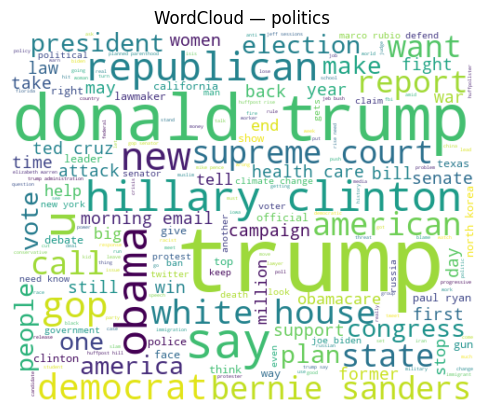

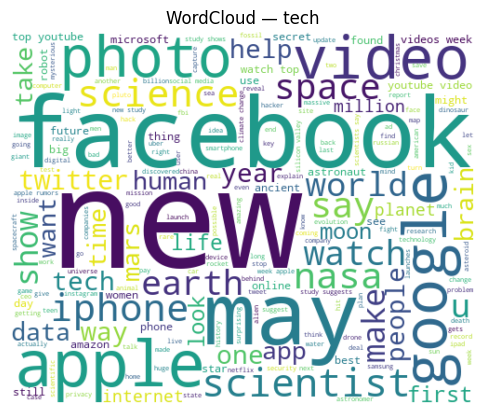

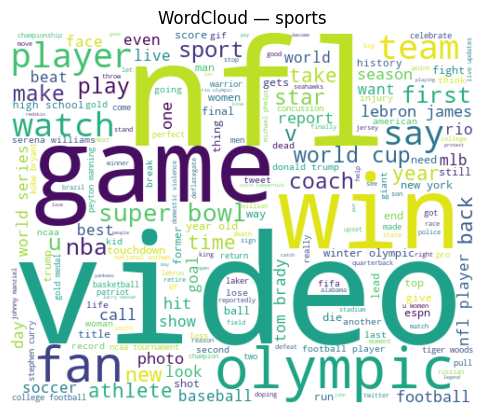

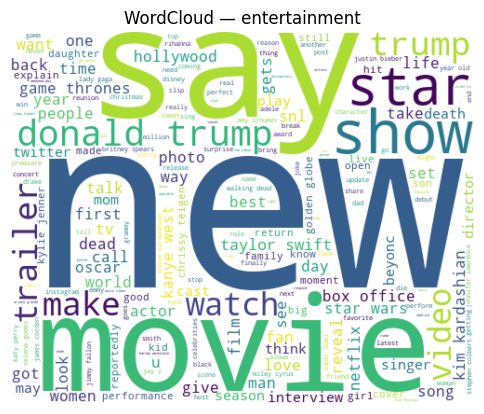

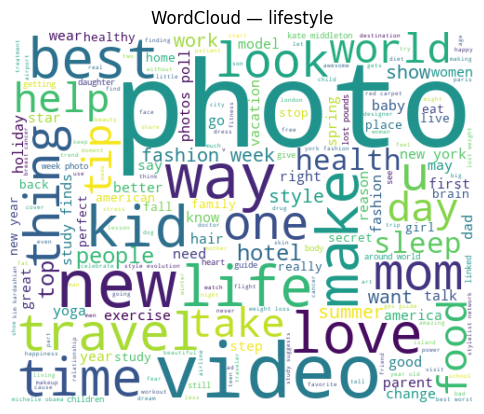

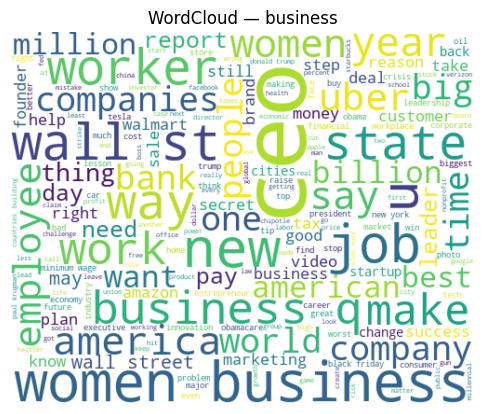

In [16]:
# ================================================================
#  Visualization: Word Clouds
# ================================================================
for cat in df['category_mapped'].unique():
    plt.figure(figsize=(6,6))
    text = " ".join(df[df['category_mapped']==cat]['clean_text'])
    wc = WordCloud(width=500, height=400, background_color="white").generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud — {cat}")
    plt.show()

In [17]:
import joblib

# Save Logistic Regression model and TF-IDF vectorizer
joblib.dump(lr_model, "lr_model.pkl")
joblib.dump(tfidf, "tfidf.pkl")

# Save Label Encoder
joblib.dump(le, "label_encoder.pkl")

# Save LSTM model
lstm_model.save("lstm_model.h5")

# Save tokenizer
joblib.dump(tokenizer, "tokenizer.pkl")

['tokenizer.pkl']